Next: https://github.com/arunarn2/HierarchicalAttentionNetworks/blob/master/HierarchicalAttn.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [26]:
from keras import backend as K
from keras.models import Model, Input, load_model
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Lambda, Activation
from keras.optimizers import RMSprop, Adam, Adamax, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.layers.merge import add
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [6]:
from src.callbacks import PlotCurves
from src.eval_metrics_seq import f1_macro, f1_micro
from src.load_data import load_data

### Load Data

In [7]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [8]:
max_len = 60
n_tags = 2
batch_size = 2

In [9]:
def get_input(data_, max_len, n_tags, is_test=False, limit=None):
    
    # limit data if not an even number when batch_size=2
    if not limit:
        limit = len(data_) if len(data_)%2 == 0 else len(data_)-1

    data_ = data_[:limit]
    
    X = []
    for article in data_:
        new_seq = []
        for i in range(max_len):
            try:
                new_seq.append(article['sentences'][i]['sentence'].replace('\n', '').strip())
            except:
                new_seq.append("ENDPAD")
        X.append(new_seq)
    
    if not is_test: 
        y = [[sent['label'] for sent in article['sentences']] for article in data_]
        y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)
        y = [[to_categorical(lab, num_classes=n_tags) for lab in sent] for sent in y]
    else:
        y = [sent['label'] for article in data_ for sent in article['sentences']]

    return np.array(X), np.array(y)

In [10]:
X_tra, y_tra = get_input(train_data, max_len, n_tags, False)
X_val, y_val = get_input(valid_data, max_len, n_tags, False)
X_test, y_test = get_input(test_data, max_len, n_tags, True)

In [11]:
X_tra.shape, X_val.shape, X_test.shape

((250, 60), (32, 60), (32, 60))

In [12]:
y_tra.shape, y_val.shape, y_test.shape

((250, 60, 2), (32, 60, 2), (441,))

### Load ELMo

In [13]:
sess = tf.Session()
K.set_session(sess)

In [14]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Build Model

In [15]:
def ELMoEmbeddingStack(x):
    embeds = []
    for art in tf.unstack(tf.transpose(x, (1, 0))):
        embeds.append(elmo(tf.squeeze(tf.cast(art, tf.string)), signature="default", as_dict=True)["default"])
    return tf.stack(embeds, 1)

###### Network fikirleri
- 2 seri bilstm
- 3 seri bilstm
- 2 residual bilstm (2 kere residual cagirarak)
- Son layer CRF
- bilstm-dropout kombinasyonlari

In [16]:
def build_model_0(max_len, n_tags):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)
        x = add([x, x_res])
        return x
    
    input_text = Input(shape=(max_len,), dtype="string")
    
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, max_len, 1024))(input_text)
    
    x = Dense(512, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
    x = residual(x)

    pred = TimeDistributed(Dense(n_tags, activation="sigmoid"))(x)

    return Model(inputs=[input_text], outputs=pred)

In [17]:
def build_model_1(max_len, n_tags):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)
        x = add([x, x_res])
        return x
    
    input_text = Input(shape=(max_len,), dtype="string")
    
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, max_len, 1024))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
                                
    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
    x = residual(x)

    pred = TimeDistributed(Dense(n_tags, activation="sigmoid"))(x)

    return Model(inputs=[input_text], outputs=pred)

In [22]:
def build_model_2(max_len, n_tags):
    
    input_text = Input(shape=(max_len,), dtype="string")
    
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, max_len, 1024))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)

    pred = TimeDistributed(Dense(n_tags, activation="sigmoid"))(x)

    return Model(inputs=[input_text], outputs=pred)

In [23]:
def build_model_3(max_len, n_tags):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(LSTM(units=256, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)
        x = add([x, x_res])
        return x
    
    input_text = Input(shape=(max_len,), dtype="string")
    
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, max_len, 1024))(input_text)
    
    x = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(embedding)
    x = residual(x)

    pred = TimeDistributed(Dense(n_tags, activation="sigmoid"))(x)

    return Model(inputs=[input_text], outputs=pred)

In [24]:
learningrate=0.0001
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [27]:
model = build_model_2(max_len, n_tags)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

W0911 22:03:07.082124 140669393625216 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0911 22:03:07.087703 140669393625216 deprecation.py:506] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0911 22:03:07.408363 140669393625216 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0911 22:03:07.412

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60)                0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, None, 60, 10 0         
_________________________________________________________________
dense_3 (Dense)              (None, None, None, 60, 25 262400    
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 60, 25 0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2)           514       
Total params: 657,154
Trainable params: 657,154
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_name = 'RQ2_test_elmo_model_2' + \
             '_maxlen_' + str(max_len) + \
             '_' + optimizer_str + \
             '_lr_' + str(learningrate) + \
             '_lrreduction' + \
             '_loss_' + loss

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train Model

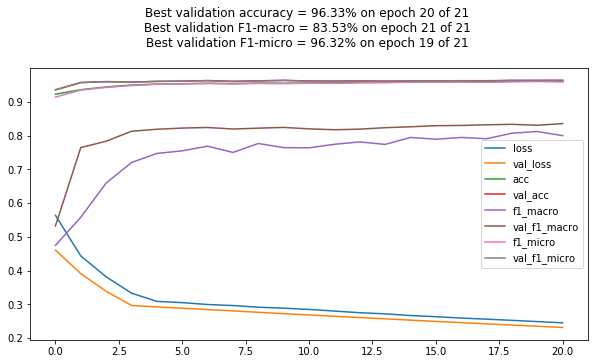

Epoch 22/50
 18/250 [=>............................] - ETA: 2:02 - loss: 0.2641 - acc: 0.9537 - f1_macro: 0.8226 - f1_micro: 0.9515

KeyboardInterrupt: 

In [29]:
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=3, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=5, mode='max')
          ])

### Load the best Model

In [30]:
model_name

'RQ2_test_elmo_model_2_maxlen_60_adam_lr_0.0001_lrreduction_loss_binary_crossentropy'

In [31]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'elmo':elmo, 'tf':tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Evaluation

In [32]:
def get_scores(model, data_, batch_size, max_len, n_tags, results_file, print_out=False):
    
    def unpad(X, y_preds):
        y_unpad = []
        for ai, art in enumerate(X):
            for si, sent in enumerate(art):
                if sent != 'ENDPAD':
                    y_unpad.append(y_preds[ai][si])
        return y_unpad
    
    X, y = get_input(data_, max_len, n_tags, True)
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = unpad(X, y_preds)
    y_preds = np.argmax(y_preds, axis=1)
    
    clsrpt = classification_report(y, y_preds)
    sfm = scikit_f1_score(y, y_preds, average='macro')
    
    if print_out:
        print(clsrpt)
        print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n')
            
    return sfm

#### Validation Set

In [33]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')
val_f1 = get_scores(best_model, valid_data, batch_size, max_len, n_tags, results_file, print_out=True)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       269
           1       0.75      0.68      0.71       130

   micro avg       0.82      0.82      0.82       399
   macro avg       0.80      0.78      0.79       399
weighted avg       0.82      0.82      0.82       399


Scikit_F1_Macro: 0.7893841642228738


#### Test Set

In [34]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')
test_f1 = get_scores(best_model, test_data, batch_size, max_len, n_tags, results_file, print_out=True)

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       325
           1       0.80      0.41      0.54       116

   micro avg       0.82      0.82      0.82       441
   macro avg       0.81      0.68      0.71       441
weighted avg       0.81      0.82      0.79       441


Scikit_F1_Macro: 0.7112871287128713
